# Implementation of zero-divergence Inference Learning in a Predictive Coding Network

## Predictive Coding Network

A predictive coding network is a probabilistic model that calculates.

Variables on adjacent levels are assumed to be related by

$$ P(x_i^l | \bar x^{l+1}) = \mathcal{N}( x_i^l; \mu_i^l, \Sigma_i^l) $$

where

$$ \mu_i^l = {\theta_i^l}^T f(\bar x^{l+1}) $$

with the objective being to maximize

$$ F = \ln P(\bar x^1,...,\bar x^{L-1} | \bar x^L) $$

due to the assumed relationship between adjacent layers this simplifies to

$$ \begin{align*}
    F &= \sum_{l=0}^{L-1} \ln P(\bar x^l | \bar x^{l+1})    \\
    &= \sum_{l=0}^{L-1} \sum_{i=1}^n \ln \mathcal{N}( x_i^l; \mu_i^l, \Sigma_i^l)    \\
    &= \sum_{l=0}^{L-1} \sum_{i=1}^n \ln \frac{1}{\sqrt{2\pi\Sigma_i^l}} - \frac{1}{2}\frac{(x_i^l - \mu_i^l)^2}{\Sigma_i^l}
\end{align*} $$

ignoring the constant term (since we are going to use the derivative with respect to $x_i^l$)

$$ F = -\frac{1}{2} \sum_{l=0}^{L-1} \sum_{i=1}^n \frac{(x_i^l - \mu_i^l)^2}{\Sigma_i^l} $$

In this model we will assume the variances to be 1, and letting $\epsilon_i^l = x_i^l - \mu_i^l$

$$ F = -\frac{1}{2} \sum_{l=0}^{L-1} \sum_{i=1}^n (\epsilon_i^l)^2 $$

to update each $x_i$ we will use the partial derivative of $F$ with respect to $x_i$

$$ \frac{\partial F}{x_i^l} = -\epsilon_i^l + f'(x_i^l) \sum_{k=1}^n \theta_{i,k}^l \epsilon_k^{l-1}$$

updating the weights
$$ \frac{\partial F}{\theta_{i,j}^l} = \epsilon_i^{l-1} f(x_j^l) $$

In [9]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PredCodMLP import PredCodMLP

In [7]:
from read_image import *

train_images = read_mnist_images('data/train-images-idx3-ubyte.gz')
train_labels = read_mnist_labels('data/train-images-idx3-ubyte.gz')
test_images = read_mnist_images('data/t10k-images-idx3-ubyte.gz')
test_labels = read_mnist_labels('data/t10k-images-idx3-ubyte.gz')

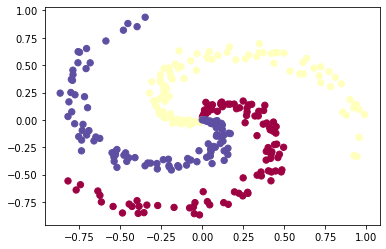

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [67]:
input = np.array([  [0,0,1],
                    [1,1,1],
                    [1,0,1],
                    [0,1,1]])

output = np.array([ [0],
                    [0],
                    [1],
                    [1]])

prednet = PredCodMLP([3,3,1])
#print(prednet.predict(input))
for i in range(10000):
    prednet.train_step(input, output, .1)
print(prednet.predict(input))

[[5.29483826e-15]
 [2.50169347e-15]
 [1.00000000e+00]
 [1.00000000e+00]]


In [24]:
Y = np.zeros((N*K,K), dtype='uint8')
for i, label in enumerate(y):
    Y[i][label] = 1

predcod = PredCodMLP([D, 32, 16, K])
for i in range(1):
    predcod.train_step(X, Y, 0.1)
preds = predcod.predict(X)
classes = np.argmax(preds, 1)
print(np.mean(y.flatten() == classes))

0.7533333333333333
